In Amir(2012)[1], they measure the dependence of the relaxation both on time $t$ and on the "waiting time" $t_w$, during which an external perturbation has been applied. And the longer $t_w$ is, the slower the resulting relaxation.

 Iter          Cost_f           Error
    0   -2.177982e+00    2.722140e+00
   71   -5.117168e+00    7.792013e-13
 Iter          Cost_f           Error
    0   -3.574643e+00    4.693652e-02
   56   -5.024732e+00    8.984714e-13
 Iter          Cost_f           Error
    0   -3.535872e+00    2.510793e-02
   55   -4.975889e+00    5.935028e-13
 Iter          Cost_f           Error
    0   -3.508617e+00    1.728256e-02
   55   -4.942419e+00    8.707845e-13
 Iter          Cost_f           Error
    0   -3.487729e+00    1.303741e-02
   53   -4.916833e+00    8.121649e-13
 Iter          Cost_f           Error
    0   -3.470775e+00    1.024149e-02
   52   -4.896069e+00    7.247189e-13
 Iter          Cost_f           Error
    0   -3.456494e+00    8.965801e-03
   52   -4.878552e+00    6.820602e-13
 Iter          Cost_f           Error
    0   -3.444129e+00    7.647683e-03
   52   -4.863381e+00    6.749922e-13
 Iter          Cost_f           Error
    0   -3.433223e+00    6.900842e-03
   51   -4.8

Execution time: 174.7173415599391


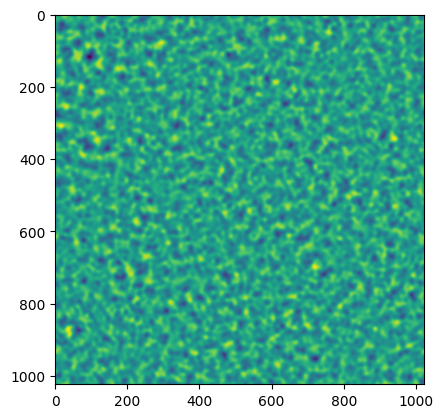

In [1]:
import tamaas as tm
import tamaas.utils
import matplotlib.pyplot as plt
import numpy as np
import time

# parallel computation
tm.initialize(8)

# Initialize threads and fftw
tm.set_log_level(tm.LogLevel.info)  # Show progression of solver

# discretization
n = 1024

# Surface generator
sg = tm.SurfaceGeneratorFilter2D([n, n])
sg.random_seed = 1

# Spectrum
sg.spectrum = tm.Isopowerlaw2D()

# Parameters
sg.spectrum.q0 = 16
sg.spectrum.q1 = 16
sg.spectrum.q2 = 64
sg.spectrum.hurst = 0.8

# Generating surface
surface = sg.buildSurface()
surface /= tm.Statistics2D.computeSpectralRMSSlope(surface)

plt.imshow(surface)

# Domain size
L = 1.

model = tm.Model(tm.model_type.basic_2d, [L, L], [n, n])

model.E = 3
model.nu = 0.5
model.E_star

shear_modulus = [3] * 100

characteristic_time = np.logspace(-3, 5, 100)


# time
t0 = 0
t1 = 20
time_steps = 100
dt = (t1 - t0) / time_steps

# Const loading
W = 1e0


#solver
solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)

Ac_tamaas = []

#solve for target pressure
p_target = W / (L**2) #avarge pressure
#solver.solve(p_target)

#reset the solver to avoid history accumulation
solver.reset()


start_time = time.perf_counter()

for t in np.linspace(t0, t1, time_steps):
    solver.solve(p_target)
    Ac_tamaas.append(tm.Statistics2D.contact(model.traction))

end_time = time.perf_counter()
execution_time = end_time - start_time
print("Execution time:", execution_time)

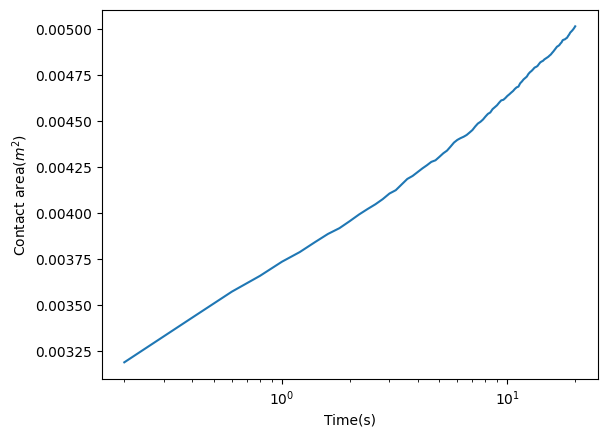

In [2]:
plt.plot(np.arange(t0, t1, dt)+dt, Ac_tamaas)
plt.xlabel("Time(s)")
plt.ylabel("Contact area($m^2$)")
plt.xscale("log")
plt.show()

#### Now we move to nonmonotonic aging

 Iter          Cost_f           Error
    0   -4.350324e+00    2.723738e+00
   73   -9.473201e+00    7.047575e-13
 Iter          Cost_f           Error
    0   -4.332774e+00    2.602419e+00
   74   -9.269029e+00    9.204486e-13
 Iter          Cost_f           Error
    0   -4.323067e+00    2.539749e+00
   73   -9.161627e+00    8.217774e-13
 Iter          Cost_f           Error
    0   -4.316240e+00    2.497303e+00
   73   -9.088176e+00    9.185093e-13
 Iter          Cost_f           Error
    0   -4.310927e+00    2.465112e+00
   75   -9.032114e+00    6.813015e-13
 Iter          Cost_f           Error
    0   -4.306554e+00    2.439137e+00
   74   -8.986647e+00    9.820153e-13
 Iter          Cost_f           Error
    0   -4.302823e+00    2.417337e+00
   73   -8.948319e+00    8.988778e-13
 Iter          Cost_f           Error
    0   -4.299561e+00    2.398540e+00
   75   -8.915165e+00    8.231327e-13
 Iter          Cost_f           Error
    0   -4.296657e+00    2.382007e+00
   74   -8.8

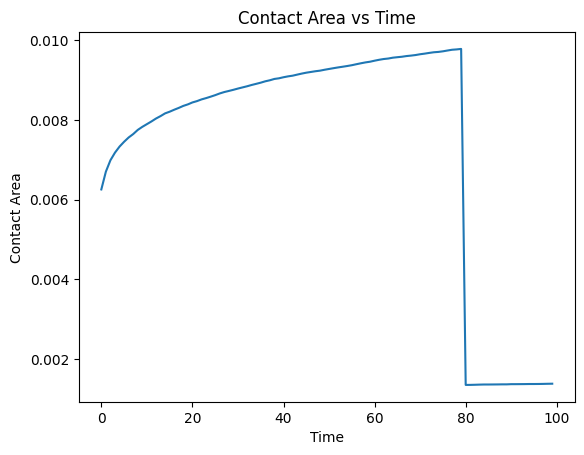

In [3]:
solver.reset()
solver = tm.MaxwellViscoelastic(model, surface, 1e-12, dt, shear_modulus, characteristic_time)

# Solve for target pressure
p_target1 = 2#avarge pressure
p_target2 = 0.25#avarge pressure

tm.Statistics2D.contact(model.traction)
model.traction[:] = 0
model.displacement[:] = 0

# Solve for target pressure
contact_area = []
for i in range(time_steps):
    model.traction[:] = 0
    model.displacement[:] = 0
    if i < 80:
        solver.solve(p_target1)
    else:
        solver.solve(p_target2)
    contact_area.append(tm.Statistics2D.contact(model.traction))


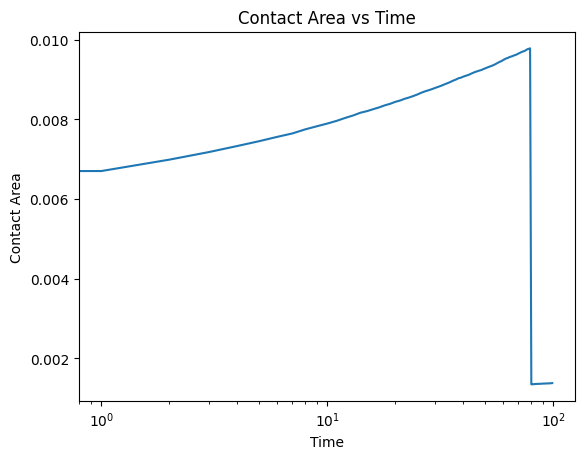

In [4]:

plt.plot(range(time_steps), contact_area)
plt.xlabel('Time')
plt.xscale("log")
plt.ylabel('Contact Area')
plt.title('Contact Area vs Time')
plt.show()

#### Reference



[1] Amir, Ariel, Yuval Oreg, and Yoseph Imry. ‘On Relaxations and Aging of Various Glasses’. Proceedings of the National Academy of Sciences 109, no. 6 (7 February 2012): 1850–55. https://doi.org/10.1073/pnas.1120147109.
